<a href="https://colab.research.google.com/github/mananchichra/Image_classification/blob/main/mlpAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset

In [ ]:
# Data transformations (normalization)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


data = pd.read_csv('/content/fashion-mnist_train.csv')
class FashionMNISTDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Separate the label from the pixel values
        label = self.data.iloc[idx, 0]
        image_array = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape(28, 28)
        image = Image.fromarray(image_array, mode='L')

        if self.transform:
            image = self.transform(image)

        return image, label

dataset = FashionMNISTDataset(data, transform=transform)

train_data, temp_data = train_test_split(dataset, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=2/3, random_state=42)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

<ipython-input-2-3f5e8ff44a2e>:29: RuntimeWarning: invalid value encountered in cast
  image_array = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape(28, 28)


In [ ]:

class MLP_Autoencoder(nn.Module):
    def __init__(self, input_size=784, hidden_dims=[256, 128], latent_dim=32):
        super(MLP_Autoencoder, self).__init__()

        # Encoder
        encoder_layers = []
        in_dim = input_size
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(in_dim, h_dim))
            encoder_layers.append(nn.ReLU())
            in_dim = h_dim
        encoder_layers.append(nn.Linear(hidden_dims[-1], latent_dim))
        encoder_layers.append(nn.ReLU())

        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder
        decoder_layers = []
        in_dim = latent_dim
        for h_dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(in_dim, h_dim))
            decoder_layers.append(nn.ReLU())
            in_dim = h_dim
        decoder_layers.append(nn.Linear(hidden_dims[0], input_size))
        decoder_layers.append(nn.Sigmoid())  # to match the pixel range of (0, 1)

        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the images
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

class MLP_Classifier(nn.Module):
    def __init__(self, input_dim=32, hidden_dims=[128, 64], output_dim=10):
        super(MLP_Classifier, self).__init__()

        classifier_layers = []
        in_dim = input_dim
        for h_dim in hidden_dims:
            classifier_layers.append(nn.Linear(in_dim, h_dim))
            classifier_layers.append(nn.ReLU())
            in_dim = h_dim
        classifier_layers.append(nn.Linear(hidden_dims[-1], output_dim))

        self.classifier = nn.Sequential(*classifier_layers)

    def forward(self, x):
        return self.classifier(x)


In [ ]:
def train_autoencoder(model, data_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, _ in data_loader:
            images = images.to(device)
            optimizer.zero_grad()

            # Forward pass
            reconstructed, _ = model(images)
            loss = criterion(reconstructed, images.view(-1, 784))

            # Backward and optimize
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(data_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


In [ ]:
def train_classifier(model, encoder, train_loader, criterion, optimizer, epochs=10):
    model.train()
    encoder.eval()  # Freeze the autoencoder's encoder during classifier training
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            images = images.view(-1, 784)
            # Forward pass through the encoder, then classifier
            latent = encoder(images)
            outputs = model(latent)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


In [ ]:
def evaluate(model, encoder, data_loader):
    model.eval()
    encoder.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            images = images.view(-1, 784)
            # Forward pass through the encoder, then classifier
            latent = encoder(images)
            outputs = model(latent)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')


In [ ]:
# Hyperparameters
input_size = 784
hidden_dim1 = [256,128]
hidden_dim2 = [128,64]
latent_dim = 32
output_dim = 10
epochs = 20

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate models
autoencoder = MLP_Autoencoder(input_size=input_size, hidden_dims=hidden_dim1, latent_dim=latent_dim).to(device)
print(latent_dim)
classifier = MLP_Classifier(input_dim=latent_dim, hidden_dims=hidden_dim2, output_dim=output_dim).to(device)

# Loss and optimizers
criterion_autoencoder = nn.MSELoss()
optimizer_autoencoder = optim.Adam(autoencoder.parameters(), lr=0.001)

criterion_classifier = nn.CrossEntropyLoss()
optimizer_classifier = optim.Adam(classifier.parameters(), lr=0.001)

# Train the autoencoder
print("Training Autoencoder...")
train_autoencoder(autoencoder, train_loader, criterion_autoencoder, optimizer_autoencoder, epochs=epochs)

# Train the classifier
print("Training Classifier...")
train_classifier(classifier, autoencoder.encoder, train_loader, criterion_classifier, optimizer_classifier, epochs=epochs)

# Evaluate the classifier
print("Evaluating Classifier...")
evaluate(classifier, autoencoder.encoder, test_loader)


32
Training Autoencoder...
Epoch [1/20], Loss: 0.6843
Epoch [2/20], Loss: 0.6234
Epoch [3/20], Loss: 0.6144
Epoch [4/20], Loss: 0.6090
Epoch [5/20], Loss: 0.6063
Epoch [6/20], Loss: 0.6044
Epoch [7/20], Loss: 0.6027
Epoch [8/20], Loss: 0.6014
Epoch [9/20], Loss: 0.6004
Epoch [10/20], Loss: 0.5995
Epoch [11/20], Loss: 0.5988
Epoch [12/20], Loss: 0.5981
Epoch [13/20], Loss: 0.5975
Epoch [14/20], Loss: 0.5969
Epoch [15/20], Loss: 0.5965
Epoch [16/20], Loss: 0.5960
Epoch [17/20], Loss: 0.5956
Epoch [18/20], Loss: 0.5951
Epoch [19/20], Loss: 0.5948
Epoch [20/20], Loss: 0.5945
Training Classifier...
Epoch [1/20], Loss: 0.9297
Epoch [2/20], Loss: 0.6415
Epoch [3/20], Loss: 0.5962
Epoch [4/20], Loss: 0.5688
Epoch [5/20], Loss: 0.5567
Epoch [6/20], Loss: 0.5447
Epoch [7/20], Loss: 0.5363
Epoch [8/20], Loss: 0.5278
Epoch [9/20], Loss: 0.5152
Epoch [10/20], Loss: 0.5107
Epoch [11/20], Loss: 0.4992
Epoch [12/20], Loss: 0.4977
Epoch [13/20], Loss: 0.4876
Epoch [14/20], Loss: 0.4853
Epoch [15/20], L

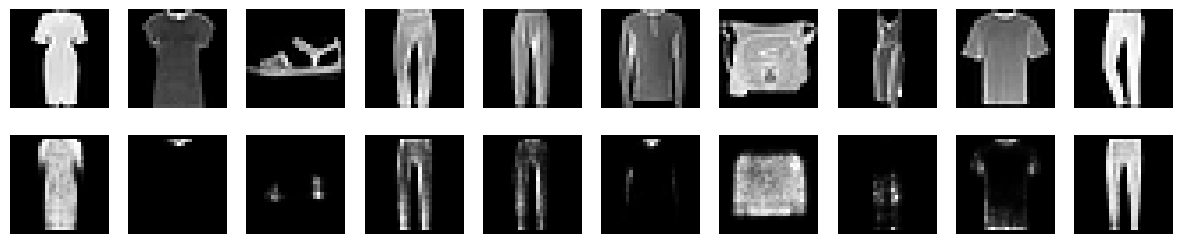

In [ ]:
def visualize_reconstructions(model, data_loader):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(data_loader))
        images = images.to(device)
        reconstructed, _ = model(images)

        # Plot original and reconstructed images
        fig, axes = plt.subplots(2, 10, figsize=(15, 3))
        for i in range(10):
            axes[0, i].imshow(images[i].cpu().squeeze(), cmap="gray")
            axes[1, i].imshow(reconstructed[i].cpu().view(28, 28), cmap="gray")
            axes[0, i].axis("off")
            axes[1, i].axis("off")
        plt.show()

# Visualize reconstructions
visualize_reconstructions(autoencoder, test_loader)


## Architecture
- **CnnAutoencoder:**
Uses convolutional layers in the encoder to capture spatial features and patterns.
The decoder often mirrors the encoder using deconvolution (transposed convolution) layers.
Preserves local spatial relationships, focusing on capturing image shapes and textures.
- **MlpAutoencoder:**
Consists of fully connected (dense) layers for both encoder and decoder.
Treats the image as a flat vector, losing the natural spatial structure of the image.
Primarily focuses on global feature extraction rather than localized spatial relationships.

##  Reconstruction Quality
- **CnnAutoencoder:**

  *Clearer Shapes:* Preserves shapes due to its localized spatial learning.  
  *Sharper Details:* Better at texture and pattern reconstruction.
- **MlpAutoencoder:**

  *Distinct Borders and Outlines:* Captures edge and boundary information more distinctly

  *Blurry Inner Details:* Lost some intricate inner details within large regions of the image because it doesn't maintain spatial hierarchies.